In [1]:
import torch # version 2.1.2
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
import cv2
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.nn.parallel import DataParallel
from model import YoloV1
from dataset import VOCDataset
from loss import YoloLoss
from utils import *

seed = 3301 #pseudorandom seed, gets the same dataset loading
torch.manual_seed(seed)

torch.autograd.set_detect_anomaly(True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", DEVICE)

Using device cuda


In [2]:
# Hyperparameters for our model
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 50
WEIGHT_DECAY = 0    # no regularization in order for fast training
EPOCHS = 100

# Other variables for training
NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FNAME = "overfit.pth.tar"
SAVE_MODEL_FNAME = "yolotrained.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"

# Creating the Datasets

In [3]:
# This cell generates a validation set
import numpy as np
np.random.seed(3301)

def split_lines(input_file, output_file_1, output_file_2, split_ratio=0.8):
    # Read lines from the input file
    with open(input_file, 'r') as infile:
        lines = infile.readlines()

    total_lines = len(lines)

    # Create a boolean mask for random selection
    random_mask = np.random.choice([True, False], total_lines, p=[split_ratio, 1.0 - split_ratio])

    # Use boolean indexing to get the selected lines
    random_lines = np.array(lines)[random_mask]

    # Write the selected lines to the first output file
    with open(output_file_1, 'w') as outfile_1:
        outfile_1.writelines(random_lines)

    # Use boolean indexing to get the remaining lines
    remaining_lines = np.array(lines)[~random_mask]

    # Write the remaining lines to the second output file
    with open(output_file_2, 'w') as outfile_2:
        outfile_2.writelines(remaining_lines)
    
input_file = 'data/train.csv'
output_file_1 = 'data/train_trimmed.csv'
output_file_2 = 'data/validation.csv'

input_file = 'data/100examples.csv'
output_file_1 = 'data/100examples_trimmed.csv'
output_file_2 = 'data/100examples_validation.csv'
# split_lines(input_file, output_file_1, output_file_2, 0.8)

In [4]:
# This cell creates the 3 datasets: train_trimmed, validation, and test

transform = transforms.Compose([
    transforms.Resize((448, 448)), 
    transforms.ToTensor()
    ])

# creating datasets/dataloaders

train_trimmed_dataset = VOCDataset(
    'data/train_trimmed.csv',
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

train_trimmed_loader = DataLoader(
    dataset = train_trimmed_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = True,
    drop_last = False       # True for training, and since numDatapoints > batchSize
)

validation_dataset = VOCDataset(
    'data/validation.csv', 
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

validation_loader = DataLoader(  # we need a loader to input into get_bboxes
    dataset = validation_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = True,
    drop_last = False       
)

test_dataset = VOCDataset(
    "data/test.csv", 
    transform = transform, 
    img_dir = IMG_DIR,
    label_dir = LABEL_DIR
)

test_loader = DataLoader( # THIS IS NOT SHUFFLED SO WE CAN PLOT VISUALIZATIONS
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = False,
    drop_last = True
)

In [5]:
# This cell defines a function to train the model on the all the datapoints in the train_loader
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE) 
        # x has shape torch.Size([batchSize, 3, 448, 448])
        # y has shape torch.Size([batchSize, 7, 7, 30])
        
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        
        # backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())
    
    total_loss = sum(mean_loss)/len(mean_loss)
    return total_loss

def yololoss_validation_evaluation(loader, model, loss_fn):
    """Given a dataset, evaluates the model's defined yolo loss on that dataset and returns it"""
    mean_loss = []
    
    model.eval()
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE) 
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
    model.train() # return the model in training mode
    
    total_loss = sum(mean_loss)/len(mean_loss)
    return total_loss


# Training Loop

In [6]:
# TRAINING THE MODEL
model = YoloV1(split_size = 7, num_boxes = 2, num_classes = 20).to(DEVICE)
model = DataParallel(model)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FNAME), model, optimizer)

# performance tracking
mAP_train_list = []
mAP_valid_list = []
avgloss_train_list = []
avgloss_valid_list = []
best_valid_mAP = 0.5

# trains through the entire dataset once
model.train()

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} Results:")
    # get_bboxes puts the model in .eval() mode to evaluate and then switches it back to model.train() when finished evaluating bboxes
    pred_boxes_train, target_boxes_train = get_bboxes(train_trimmed_loader, model, iou_threshold = 0.5, prob_threshold = 0.4)
    pred_boxes_valid, target_boxes_valid = get_bboxes(validation_loader, model, iou_threshold = 0.5, prob_threshold = 0.4)
    # pred_boxes (list of lists) = [[train_idx, class_prediction, prob_score, x1, y1, x2, y2],...], each list within the big list represents a bbox
    # target_boxes = ^
    # note: the length of these lists >= numDatapoints
    
    # Calculate the mAP from our evaluated bboxes
    mAP_train = mean_average_precision(pred_boxes_train, target_boxes_train, iou_threshold=0.5, box_format="midpoint")
    mAP_valid = mean_average_precision(pred_boxes_valid, target_boxes_valid, iou_threshold=0.5, box_format="midpoint")
    mAP_train_list.append(mAP_train)
    mAP_valid_list.append(mAP_valid)
    print(f"Train mAP: {mAP_train}")
    print(f"Validation mAP: {mAP_valid}")
    
    # Calculate the average YOLO loss from our evaluated bboxes
    yolo_loss_train = train_fn(train_trimmed_loader, model, optimizer, loss_fn)
    yolo_loss_valid = yololoss_validation_evaluation(validation_loader, model, loss_fn)
    print(f"Average training loss per image: {yolo_loss_train}")
    print(f"Average validation loss per image: {yolo_loss_valid}")
    avgloss_train_list.append(yolo_loss_train)
    avgloss_valid_list.append(yolo_loss_valid)
    print()

    # early stopping - once validation mAP hits .5, we start saving the model with the best validation mAP
    if mAP_valid > best_valid_mAP:
        best_valid_mAP = mAP_valid
        torch.save(model, "yolotrained.tar")

checkpoint = {
    "state_dict": model.state_dict(),
    "optimizer": optimizer.state_dict(),
}
save_checkpoint(checkpoint, filename=SAVE_MODEL_FNAME) # saves the model with torch.save

Epoch 1 Results:
Train mAP: 0.0
Validation mAP: 0.0


100%|██████████| 133/133 [02:29<00:00,  1.13s/it, loss=1.24e+3]


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/ObjectDetectSJTU/model.py", line 61, in forward
    x2 = self.darknet(x) # x2 has shape torch.Size([batchSize, 1024, 7, 7])
         ^^^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/modules/container.py", line 215, in forward
    input = module(input)
            ^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/ObjectDetectSJTU/model.py", line 35, in forward
    return self.leakyrelu(self.batchnorm(self.conv(x)))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/modules/activation.py", line 774, in forward
    return F.leaky_relu(input, self.negative_slope, self.inplace)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anthony/miniconda3/lib/python3.11/site-packages/torch/nn/functional.py", line 1646, in leaky_relu
    result = torch._C._nn.leaky_relu(input, negative_slope)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 14.58 GiB of which 9.31 MiB is free. Including non-PyTorch memory, this process has 14.56 GiB memory in use. Of the allocated memory 13.30 GiB is allocated by PyTorch, and 166.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


In [8]:
# this cell saves the model
torch.save(model, "yolotrained.tar")

In [9]:
# this cell loads the model
tar_file_path = "yolotrained.tar"
model = torch.load(tar_file_path)
model(torch.rand(10, 3, 448, 448)) # testing if we got it :D

tensor([[ 0.8807,  0.1358, -0.6699,  ..., -0.1170, -0.4798,  0.1161],
        [ 0.7900,  0.1338, -0.6590,  ..., -0.0189, -0.3634, -0.3226],
        [ 0.9181,  0.0933, -0.6743,  ..., -0.0707, -0.5439, -0.0306],
        ...,
        [ 0.8949, -0.0743, -0.9245,  ...,  0.0564, -0.4983, -0.2872],
        [ 0.8199,  0.0577, -0.9367,  ...,  0.0990, -0.4403, -0.1835],
        [ 0.6988,  0.0890, -0.8158,  ...,  0.1070, -0.5278, -0.2102]],
       device='cuda:0', grad_fn=<GatherBackward>)

In [5]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 448, 448))

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [100, 1470]               --
├─YoloV1: 1-1                            [25, 1470]                85,787,534
├─YoloV1: 1-8                            --                        (recursive)
│    └─Sequential: 2-1                   [25, 1024, 7, 7]          60,169,152
│    └─Sequential: 2-27                  --                        (recursive)
│    │    └─CNNBlock: 3-1                [25, 64, 224, 224]        9,536
│    │    └─CNNBlock: 3-20               --                        (recursive)
├─YoloV1: 1-3                            [25, 1470]                --
├─YoloV1: 1-8                            --                        (recursive)
│    └─Sequential: 2-3                   [25, 1024, 7, 7]          --
│    └─Sequential: 2-27                  --                        (recursive)
│    │    └─CNNBlock: 3-3                [25, 64, 224, 224]        --
│    │    └─CNNBlock:

In [22]:
# Let's evaluate the model on the training set and test test: (takes about 60 seconds)

train_loader_INORDER = DataLoader(
    dataset = 'train_trimmed.csv',
    batch_size = BATCH_SIZE,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
    shuffle = False,        # To keep in order to see results
    drop_last = False       # False since we don't want to drop any matches
)

pred_boxes_train, target_boxes_train = get_bboxes(train_loader_INORDER, model, iou_threshold = 0.5, prob_threshold = 0.4)
pred_boxes_test, target_boxes_test = get_bboxes(test_loader, model, iou_threshold = 0.5, prob_threshold = 0.25)

print("Final Training mAP:", mean_average_precision(pred_boxes_train, target_boxes_train))
print("Final Testing mAP:", mean_average_precision(pred_boxes_test, target_boxes_test))


Final Testing mAP: tensor(0.0437)


In [39]:
pascal_voc_classes = {
    0: 'airplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle',
    5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 
    10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person',
    15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'TVmonitor',
}

classEnum_to_color = {
    0: 'red', 1: 'blue', 2: 'green', 3: 'purple', 4: 'orange', 
    5: 'cyan', 6: 'magenta', 7: 'yellow', 8: 'brown', 9: 'lime',
    10: 'pink', 11: 'teal', 12: 'olive', 13: 'navy', 14: 'indigo',
    15: 'maroon', 16: 'gold', 17: 'orchid', 18: 'turquoise', 19: 'slategray'
}

# Results and Performance
The following cells plot the results outputted by the model as well as their respective labels, as well as loss and mAP over the epochs.

Text(0, 0.5, 'mAP (Mean Average Precision)')

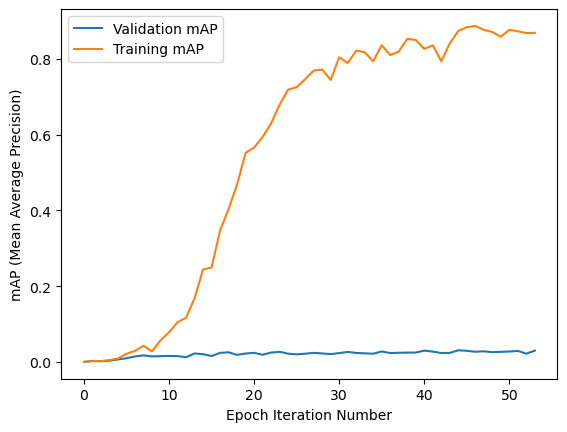

In [9]:
plt.plot(range(len(mAP_valid_list)), [x.item() for x in mAP_valid_list], label='Validation mAP')
plt.plot(range(len(mAP_train_list)), [x.item() for x in mAP_train_list], label='Training mAP')
plt.legend()
plt.xlabel("Epoch Iteration Number")
plt.ylabel("mAP (Mean Average Precision)")

In [9]:
# NOTE: to generate successful plots, shuffling has to be OFF in the dataloader
def plot_bbox_on_img(csv_file, pd_index, boxes):
    """
    Input:
        1. csv_file = fname of csv_file to create dataset
        2. pd_index = which datapoint+label in that dataset
        3. boxes (list of lists) = [[train_idx, class_prediction, prob_score, x1, y1, x2, y2],...], each list within the big list represents a bbox
    Output:
        Image (1 datapoint) with bounding boxes drawn on them!
    """
    fname_dataframe = pd.read_csv("data/" + csv_file)
    image_fname = "data/images/" + fname_dataframe.iloc[pd_index, 0]
    bboxes = [box for box in boxes if box[0] == pd_index]
    plot_image(cv2.imread(image_fname)[...,::-1], bboxes, classEnum_to_color, pascal_voc_classes)

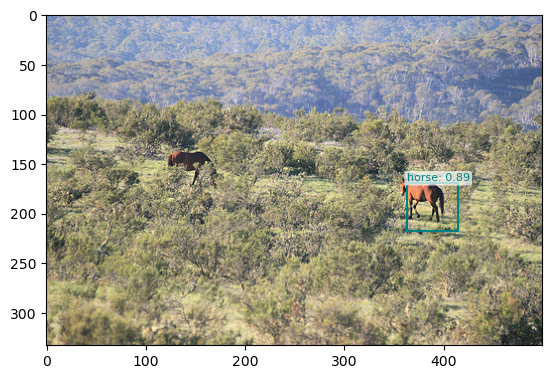

In [30]:
# boxes is either 'target_boxes' or 'pred_boxes'
plot_bbox_on_img("train.csv", 16000, pred_boxes_train)

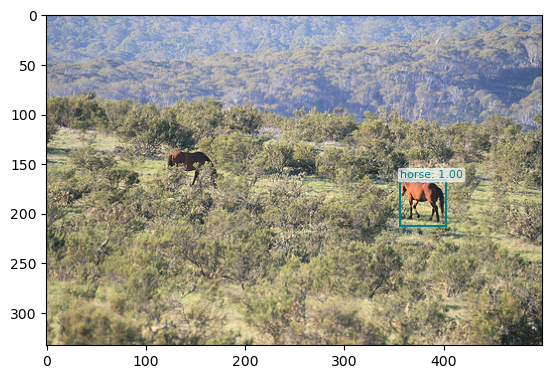

In [35]:
plot_bbox_on_img("train.csv", 16000, target_boxes_train)

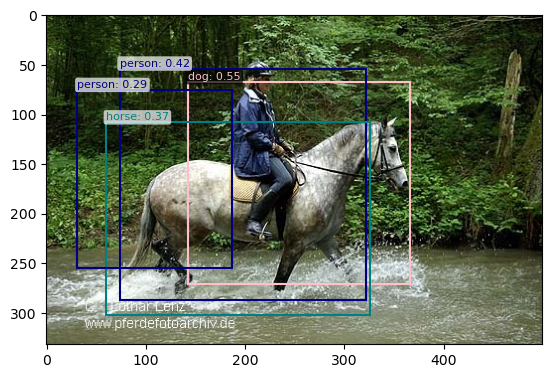

In [38]:
plot_bbox_on_img("test.csv", 11, pred_boxes_test)

In [ ]:
plot_bbox_on_img("test.csv", 11, pred_boxes_test)

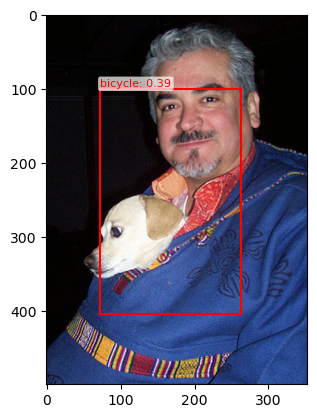

In [28]:
plot_image(cv2.imread("data/images/000001.jpg")[...,::-1], [box for box in pred_boxes_test if box[0] == 0], classEnum_to_color, pascal_voc_classes)

In [ ]:
plot_image(cv2.imread("data/images/000007.jpg")[...,::-1], [box for box in target_boxes if box[0] == 0], classEnum_to_color, pascal_voc_classes)

In [ ]:
plot_image(cv2.imread("data/images/000009.jpg")[...,::-1], [box for box in pred_boxes if box[0] == 1], classEnum_to_color, pascal_voc_classes)

In [ ]:
plot_image(cv2.imread("data/images/000009.jpg")[...,::-1], [box for box in target_boxes if box[0] == 1], classEnum_to_color, pascal_voc_classes)
print([box for box in target_boxes if box[0] == 1])

In [ ]:
plot_image(cv2.imread("data/images/000016.jpg")[...,::-1], [box for box in pred_boxes if box[0] == 2], classEnum_to_color, pascal_voc_classes)
print([box for box in pred_boxes if box[0] == 2])

In [ ]:
plot_image(cv2.imread("data/images/000016.jpg")[...,::-1], [box for box in target_boxes if box[0] == 2], classEnum_to_color, pascal_voc_classes)